## Clean for Daily Return ##

In this notebook I clean the data for use in computing the daily return distributions. It is different than the other "clean_spy" notebook because it takes log-returns over the entire time period -- It does not drop the first return in the day; it starts with second by second data; and it removes market microstructure noise.

In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import data_cleaning as clean
from functools import partial
from scipy import stats

In [2]:
%matplotlib inline
plt.style.use('seaborn-talk')
# %pdb on

In [3]:
years = range(2014, 2014)

In [ ]:
spy_full_prices = pd.concat([pd.read_csv('../data/spy_raw_' + str(year) + '_3_sec.csv', header=0, parse_dates=[[1,2]]) 
                   for year in years])

In [23]:
spy_full_prices = pd.read_csv('../data/spy_2012_raw.csv', parse_dates=[[1,2]])

In [24]:
spy_full_prices.head()

DATE_TIME SYMBOL   PRICE  SIZE  G127  CORR COND EX    itime  \
0 2012-01-03 09:30:00    SPY  127.77   200     0     0  NaN  T  9:30:00   
1 2012-01-03 09:30:01    SPY  127.79   400     0     0    F  T  9:30:01   
2 2012-01-03 09:30:02    SPY  127.80   100     0     0    F  T  9:30:02   
3 2012-01-03 09:30:03    SPY  127.81   100     0     0    @  P  9:30:03   
4 2012-01-03 09:30:04    SPY  127.83   300     0     0    F  Z  9:30:04   

     rtime    iprice  
0  9:30:00  127.7700  
1  9:30:00  127.7900  
2  9:30:01  127.8000  
3  9:30:02  127.8000  
4  9:30:03  127.8205

In [25]:
log_prices = pd.DataFrame(np.log(spy_full_prices['PRICE'].values), index=spy_full_prices['DATE_TIME'], 
                                     columns=['log_price'])

In [26]:
log_prices_1sec = log_prices.resample('1s').last()

In [27]:
real_vol = log_prices.resample('5min').last().diff().groupby(pd.TimeGrouper('D')).apply(lambda x: np.sum(x**2))
real_vol.columns = ['real_vol']

In [28]:
log_prices_1sec.head()

log_price
DATE_TIME                     
2012-01-03 09:30:00   4.850232
2012-01-03 09:30:01   4.850388
2012-01-03 09:30:02   4.850467
2012-01-03 09:30:03   4.850545
2012-01-03 09:30:04   4.850701

In [29]:
log_returns_1_sec = log_prices_1sec.diff()
log_returns_1_sec.columns = ['log_returns']

In [30]:
num_obs_per_day = log_prices.groupby(pd.TimeGrouper('D')).count().resample('1s').ffill()
num_obs_per_day.columns = ['num_obs_per_day']

In [31]:
joined_data = pd.concat([real_vol.resample('1s').ffill(), log_prices_1sec, log_returns_1_sec, num_obs_per_day], 
                        axis=1, join='inner')

In [32]:
joined_data.count()

real_vol           21479401
log_price           4365209
log_returns         3505418
num_obs_per_day    31329001
dtype: int64

In [33]:
# I choose the percentile so that given the number of datapoints given a laplace distribution with the correct
# variance we would exlude one datapoint by accident with 25% probability over the entire sample period. 
std_dev_val = stats.laplace.ppf( 1 - .25 / joined_data['num_obs_per_day'].count())
mean_return = joined_data['log_returns'].mean()
trimmed_data = joined_data.query('abs(log_returns - @mean_return) <= @std_dev_val * sqrt(real_vol / num_obs_per_day)')

In [34]:
std_dev_val

17.953201963416205

In [35]:
#trimmed_data['log_price'].to_hdf('../data/spy_2012_1sec.hdf', 'table', compression=9)

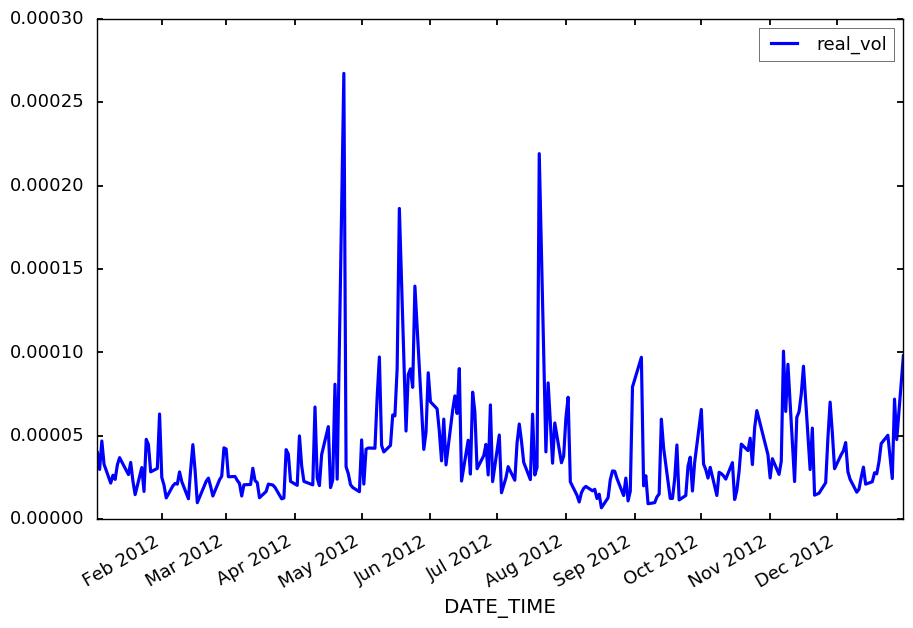

In [36]:
real_vol.dropna().plot()

In [22]:
log_prices.to_hdf('spy_2014_1sec.hdf', 'table')

In [21]:
log_prices.resample('1s').last().groupby(pd.TimeGrouper('D')).count().query('log_price > 0').max()

log_price    23332
dtype: int64

First, I simply save a downsampled version of all of the data contained in spy_full_prices

In [ ]:
log_prices_downsampled = log_prices.resample(rule='5min', label='right', closed='right').last()

In [ ]:
log_returns_downsampled = log_prices_downsampled.groupby(pd.TimeGrouper('D')).diff().dropna()

In [ ]:
log_returns_to_save = log_returns_downsampled.groupby(pd.TimeGrouper('H')).filter(
    lambda x : np.all(9 < x.index.hour) and np.all(x.index.hour < 16))

In [ ]:
# DO I really want to  diff this?
log_prices.diff().dropna().to_hdf('../data/spy_not_downsampled_3sec_' + str(np.amin(years)) + '_' + str(np.amax(years)) + 
                     '.tmp.hdf', 'table', header=True)

I now take the simplest market microstructure adjustement and run an MA(1) filter. I do this on the log_price process itself. 

In [ ]:
filtered_states, noise_var = clean.remove_ma_noise(log_prices)
filtered_data = pd.DataFrame(filtered_states, index=log_prices.index)

In [ ]:
data =  log_prices

In [ ]:
# filtered_data  log_prices

I now take the data and within each day convert it into equal intervals. By doing it this way, I am able to create a square dataframe. In addition, it is a more natural way to do the asymptotics, because the you have an identical fraction in each of the days. 

In [ ]:
grouped_rtns = log_prices.groupby(pd.TimeGrouper('D')) 
downsampled_data = pd.concat([clean.downsample(day, num=1750) for _, day in  grouped_rtns if day.size > 0])
days = downsampled_data.diff()[lambda x : (-.1 < x) & (x < .1)].dropna()

In [ ]:
days.groupby(pd.TimeGrouper('D')).sum().dropna().loc['2007-01':'2010-06'].plot(ylim=[-.08, .08])

In [ ]:
filtered_returns = days.diff()
days.to_hdf('../data/spy_rtn_for_daily_rtn_' + str(np.amin(years)) + '_' + str(np.amax(years)) + 
                     '_clean.tmp.hdf', 'table', header=True)

In [ ]:
log_returns = pd.Series(np.array([day.values for day in days]).ravel(), 
                        index=np.array([day.index for day in days]).ravel()).diff().dropna()

I now convert the series into a 2d array of values

In [ ]:
log_returns.plot()

In [ ]:
np.mean(log_prices)

In [ ]:
log_returns.to_hdf('../data/spy_rtn_for_daily_rtn_' + str(np.amin(years)) + '_' + str(np.amax(years)) + 
                    '_clean.tmp.hdf', 'table', header=True)
filtered_data.to_hdf('../data/spy_not_downsampled_' + str(np.amin(years)) + '_' + str(np.amax(years)) + 
                     '_clean.tmp.hdf', 'table', header=True)

In [ ]:
np.sum((log_returns == 0))

In [ ]:
log_returns.plot(kind='kde')